<a href="https://colab.research.google.com/github/suvosree/NIDS_thesis/blob/reduce_overfitting/reduce_overfitting_NIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow notebook to evaluate deep/dense NN and RNN for the NSL-KDD IDS dataset

In [ ]:
#! pip install pyyaml h5py  # Required to save models in HDF5 format
from google.colab import drive
import shutil
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#! mkdir "/content/drive/MyDrive/Colab Notebooks/IDS/NSL-KDD/models"
! ls "/content/drive/MyDrive/Colab Notebooks/IDS/NSL-KDD"

model  models


# Useful functions to load/preprocess IDS dataset NSL-KDD

In [ ]:
# NSL - KDD Intrusion Detection Notebook

# uses how to from https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers#create_an_input_pipeline_using_tfdata 

import tensorflow as tf
from tensorflow.keras import layers , regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import time
import urllib


# local path for the data:
prjdir = "ids"
datadir = "kdd_nsl"
dirpath = os.path.join(prjdir, datadir)

# URL  of the PRE-PROCESSED Train dataset:
train_url_preprocessed = "http://wisenet.fau.edu/data/NSL_KDD_Train-proc.zip"
test_url_preprocessed = "http://wisenet.fau.edu/data/NSL_KDD_Test-proc.zip"

# Original CSV URLs:
train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'


local_train_url = os.path.join(dirpath, "NSL_KDD_Train.csv")
local_test_url = os.path.join(dirpath, "NSL_KDD_Test.csv")

modeldir = os.path.join(dirpath, "models")

col_names = ["duration","protocol_type","service","flag","src_bytes",
  "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
  "logged_in","num_compromised","root_shell","su_attempted","num_root",
  "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
  "is_host_login","is_guest_login","count","srv_count","serror_rate",
  "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
  "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
  "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
  "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
  "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# how to pre-process each column: cont:normalize 0-1, cat:categorical,
#  keep:don't change
col_proc = {0:"cont", 1:"cat", 2:"cat", 3:"cat", 4:"cont", 5:"cont", 
            6:"keep", 7:"keep", 8:"keep", 9:"cont", 10:"cont",
            11:"keep", 12:"cont", 13:"keep", 14:"keep", 15:"cont",
            16:"cont", 17:"keep", 18:"keep", 19:"keep", 20:"keep",
            21:"keep", 22:"cont", 23:"cont", 24:"keep", 25:"keep", 
            26:"keep", 27:"keep", 28:"keep", 29:"keep", 30:"keep", 
            31:"cont", 32:"cont", 33:"cont", 34:"keep", 35:"keep", 
            36:"keep", 37:"keep", 38:"keep", 39:"keep", 40:"keep"}

# ===========================================================
def mk_dir(dirname:str):
  """Create a new directory and don't complain if it already eists."""
  try:
    os.mkdir(dirname)
  except IOError:
    pass


def dataframe_read(url, header=0):
  """ Reads a remote CSV file and caches local copy.
  Returns a pandas dataframe.
  """
  try:
    os.mkdir(prjdir)
    os.mkdir(dirpath)
  except FileExistsError:
    pass # ignore
 
  path = tf.keras.utils.get_file(origin=url, cache_dir=prjdir, 
                                cache_subdir=datadir)
  
  if header == 0: 
    dataframe = pd.read_csv(path, header=header, names=col_names)
  else:
    dataframe = pd.read_csv(path, header=header)

  # parsing error if  dtype=np.float32:
  #  dataframe = pd.read_csv(path, header=header, names = col_names, dtype=np.float32)
  print("dataframe_read: read ", url, " with shape ", dataframe.shape)
  return dataframe


# ======================================================================

# from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling
def UNUSED_get_rescaling_layer(name, scale):
  scaler = layers.Rescaling(scale=scale, offset=0)
  return scaler


# ----------------------------------------------------------------------------

# from https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers 
# param df_col is a dataframe column.
def get_category_encoding_layer(name, dtype, adapt_to, max_tokens=None):
  """
  Used to convert categorical features to one-hot encoding.
  """
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(adapt_to)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))



def normalize_column(pdcol, adapt_col):
  """
     Returns a mean 0 - stdev 1 normalized ndarray column using adapt_col for mean and stdev.
  """
  mean = adapt_col.mean()
  stdev = np.std(adapt_col)
  return (pdcol - mean) / stdev


def load_preprocess_df(fileurl, suffix, df_train=None):
  """ Loads and preprocesses a dataframe with the data in the CSV from fileurl.
  Saves a local copy of the expanded dataframe with scaled features and 
  categorical features transformed.
  Next time it will load the dataframe from the local expanded, preprocessed CSV file. 
  
  If df_train is a non-processed dataframe it will be used normalize columns as necessary.
  We need df_train for cat. encoding and normalization for the test dataset. 

  Returns tuple (preprocessed pd.DataFrame, original pd.DataFrame)
  """
  urlpath = urllib.parse.urlparse(fileurl).path
  basefilename = os.path.basename(urlpath).split(".")[0]
  processed_csvname = os.path.join(dirpath, basefilename + "-" + suffix + ".csv")

  # uncomment next to prepare a very small file, good for debugging:
  # df = dataframe_read(fileurl, header=0)[:10000]
  df = dataframe_read(fileurl, header=0)

  # print("load_preprocess_df df.shape=", df.shape)

  if os.path.isfile(processed_csvname):
    print("Pre-processed file exists; loading local copy {} ...".format(processed_csvname))
    # return pd.read_csv(processed_csvname, sep=",", header=1)
    return (pd.read_csv(processed_csvname, sep=","), df)

  print("fileurl=", fileurl)
  print("no local preprocessed copy of data. Preprocess and save local copy to", processed_csvname)
  # replace label with binary 'target' attribute (0=Normal, 1=Attack)
  # np_labels = np.where(df['label'] == 'normal', 0, 1)  

  # 5-class:
  # 0=Normal, 1=DoS, 2=Probe, 3=R2L, 4=U2R
  np_labels = df['label'].replace({ 'normal': 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})

  # one class per attack:
  # np_labels = df['label'].replace({ 'normal': 0, 'neptune' : 1 ,'back': 2, 'land': 3, 'pod': 4, 'smurf': 5, 'teardrop': 6,'mailbomb': 7, 'apache2': 8, 'processtable': 9, 'udpstorm': 10, 'worm': 11,
  #                          'ipsweep' : 12,'nmap' : 13,'portsweep' : 14,'satan' : 15,'mscan' : 16,'saint' : 17
  #                          ,'ftp_write': 18,'guess_passwd': 19,'imap': 20,'multihop': 21,'phf': 22,'spy': 23,'warezclient': 24,'warezmaster': 25,
  #                          'sendmail': 26,'named': 27,'snmpgetattack': 28,'snmpguess': 29,'xlock': 30,'xsnoop': 31,'httptunnel': 32,
  #                          'buffer_overflow': 33,'loadmodule': 34,'perl': 35,'rootkit': 36,'ps': 37,'sqlattack': 38,'xterm': 39})

  df.pop("label")

  ds_cols = list()
  ds_colnames = list()
  newindex = 0       # used to keep track of the current column number in the new dataframe

  for colno in range(len(col_proc)):
    cn = col_names[colno]
    #print("col: ", cn, " - ", df[cn].dtypes)
    if cn == "label":  # should not happen
      continue
    c = df[cn]
    if col_proc[colno] == 'cat':
    # if c.dtypes == 'object':
      # categorical:
      print("categorical feature", cn, end="... ")
      t0 = time.clock_gettime_ns(0)
      dsc = tf.data.Dataset.from_tensor_slices(c)
      encoding_fun = get_category_encoding_layer(cn, "string",
                            dsc if df_train is None else df_train[cn])
      
      mapped_ds = dsc.map(encoding_fun)
      
      # next is an ndarray with 2 or more columns:
      enc_cat = np.array(list(iter(mapped_ds.as_numpy_iterator())))
      t1 = time.clock_gettime_ns(0)
      print("shape={} time to convert={} s".format(enc_cat.shape, (t1 - t0)/1E9))

      for i in range(enc_cat.shape[1]):
        if True or enc_cat.any():
          newindex += 1
          ds_cols.append(enc_cat[:, i])
          ds_colnames.append(cn + str(i))
          #print("   appended", ds_colnames[-1])

      #print(c[:10])
      #print(enc_cat[:10, :])

    elif col_proc[colno] == "cont":   # normalize
    # elif df[cn].dtypes in ['float', 'int64']:
      ds_colnames.append(cn)
      # normalize with mean 0 and stdev 1:
      norm_col = normalize_column(c, c if df_train is None else df_train[cn])
      ds_cols.append(norm_col)
      newindex += 1
    elif col_proc[colno] == "keep":   # keep unchanged
      ds_colnames.append(cn)
      ds_cols.append(c)
      newindex += 1
    else:
      print("ERROR: wrong column processing type:", col_proc[colno])
      raise ValueError("ERROR: wrong column processing type: {}".format(col_proc[colno]))

  ds_cols.append(np_labels)
  ds_colnames.append("labels")    
  dfn = pd.DataFrame( { ds_colnames[i] : ds_cols[i] for i in range(len(ds_cols)) } )
  print("Processed dataframe shape is", dfn.shape, ". Save as ", processed_csvname)

  # save (cache) dataframe on the local file system:
  dfn.to_csv(processed_csvname, sep=",", index=False, header=ds_colnames)
  return (dfn, df)





# Loading data and preprocessing if needed

Attempt by default to load the preprocessed datasets stored online. The else branch is used to generate thee pre-processed datasets. Later once can upload them and post them online.

In [ ]:

if True:
  # load preprocessed datasets 
  df_train = dataframe_read(train_url_preprocessed, header=1)
  df_test = dataframe_read(test_url_preprocessed, header=1)
else:
  # Run this only if the preprocessed datasets are not available:
  # load and preprocess datasets
  #    also save local copies:
  (df_train, df_train_orig) = load_preprocess_df(train_url, "proc", df_train=None)

  print("train shape:", df_train.shape, "orig train shape:", df_train_orig.shape, )

  (df_test, df_test_orig) = load_preprocess_df(test_url, "proc", df_train_orig)

  print("test shape:", df_test.shape, "orig test shape:", df_test_orig.shape, )

  # garbage collect the original dataframes - not needed anymore.
  df_test_orig = None
  df_train_orig = None


6559375/6559375 [==============================] - 1s 0us/step
dataframe_read: read  http://wisenet.fau.edu/data/NSL_KDD_Train-proc.zip  with shape  (125971, 126)
1192097/1192097 [==============================] - 0s 0us/step
dataframe_read: read  http://wisenet.fau.edu/data/NSL_KDD_Test-proc.zip  with shape  (22542, 126)


In [ ]:
# col = 41
# print("first 10:", adata[:18,col])
# print("min:", adata[:,col].min(), "max:", adata[:,col].max(), "mean:", adata[:,col].mean(), "\n", "maxindex:", adata[adata[:,col].argmax()])


In [ ]:
! ls -la ids/kdd_nsl/

# ! zip ids/kdd_nsl/NSL_KDD_Train-proc.zip ids/kdd_nsl/NSL_KDD_Train-proc.csv
# ! zip ids/kdd_nsl/NSL_KDD_Test-proc.zip ids/kdd_nsl/NSL_KDD_Test-proc.csv
# ! ls -la ids/kdd_nsl/

# ! rm ids/kdd_nsl/*

#tf.__version__
## uncomment next 2 lines to download the processed file to your PC:
# from google.colab import files
# files.download("ids/kdd_nsl/NSL_KDD_Train-proc.zip")
# files.download("ids/kdd_nsl/NSL_KDD_Train-proc.csv")
# files.download("ids/kdd_nsl/NSL_KDD_Test-proc.zip")
# files.download("ids/kdd_nsl/Dense2-32.png")
# files.download("ids/kdd_nsl/Dense3-32.png")
# files.download("ids/kdd_nsl/LSTM-32.png")
# files.download("ids/kdd_nsl/LSTM-stacked.png")
# files.download("ids/kdd_nsl/LSTM-stk-dense.png")

#plt.imshow(plt.imread(os.path.join(dirpath, "LSTM-stk-dense.png")))


total 7584
drwxr-xr-x 2 root root    4096 Mar 20 22:31 .
drwxr-xr-x 3 root root    4096 Mar 20 22:31 ..
-rw-r--r-- 1 root root 1192097 Mar 20 22:31 NSL_KDD_Test-proc.zip
-rw-r--r-- 1 root root 6559375 Mar 20 22:31 NSL_KDD_Train-proc.zip


# Split training dataset into training and validation:

In [ ]:
def dataframe_printinfo(df):
  print("Dataframe shape:", df.shape, "\n")
  #print('Label distribution:')
  #print(df['label'].value_counts())
  categ_colnames = [cn for cn in df.columns if df[cn].dtypes == 'object']
  print("Categorical columns: ", categ_colnames)
  print([df[cn].dtypes  for cn in df.columns])


#-----------------------------------------------------------------------------
def df2ts_shuffle_split2(dataframe, split_f, shuffle=False):
  n = dataframe.shape[0]
  n_train = int(n * split_f)
  n_valid = n - n_train

  df = dataframe
  if shuffle:
    df = dataframe.sample(frac=1)

  df_train = df[:n_train]
  df_valid = df[n_train:]
  # return (tf.convert_to_tensor(df_train), tf.convert_to_tensor(df_valid))
  return (df_train, df_valid)

def df2ts_shuffle_split(dataframe, split_f, shuffle=False):
  n = dataframe.shape[0]
  n_train = int(n * split_f[0])
  n_test = int(n * split_f[1])
  n_valid = n - n_train - n_test

  df = dataframe
  if shuffle:
    df = dataframe.sample(frac=1)

  df_train = df[:n_train]
  df_test = df[n_train:(n_train+n_valid)]
  df_valid = df[(n_train+n_valid):]
  # return (tf.convert_to_tensor(df_train), tf.convert_to_tensor(df_test), tf.convert_to_tensor(df_valid))
  return (df_train, df_test, df_valid)


#dataframe_printinfo(dataframe)

# split 0.7/0.2/0.1
# (ds_train, ds_valid, ds_test) = dataset_prepare(dataframe, split_f=(0.70, 0.20), 
#                                                 shuffle=False, batch_size=16)

np.random.seed(10)


# Split the original training dataset into training + validation:

# (ts_train, ts_valid, ts_test) = df_shuffle_split(dataframe, split_f=(0.70, 0.20), shuffle=False)
(df_train_split, df_valid_split) = df2ts_shuffle_split2(df_train, split_f=0.80, shuffle=True)

print("df train split shape:", df_train_split.shape, " df valid split shape:", df_valid_split.shape)

df train split shape: (100776, 126)  df valid split shape: (25195, 126)


In [ ]:
#TESTING TESTING TESTING
def test_code():
  model = tf.keras.models.Sequential()

  #dense = tf.keras.layers.Dense(32,  input_shape=df_train.shape, activation="relu")
  #dense = tf.keras.layers.Dense(32, input_shape=(None, None, df_train.shape[1]-1), activation="relu")
  dense = tf.keras.layers.Dense(32, activation="relu")
  model.add(dense)
  # output = tf.keras.layers.Dense(20, activation="softmax")
  output = tf.keras.layers.Dense(5, activation="softmax")
  model.add(output)

  model.compile(optimizer='adam',                  
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=["accuracy"])

  hist = model.fit(x=ts_train[:,:-1], y=ts_train[:,-1], validation_data=(ts_valid[:,:-1],ts_valid[:,-1]) , epochs=5, verbose=1)
  # hist = model.fit(x=tstrain[:,:-1], y=tstrain[:,-1], epochs=5, verbose=1)
  # hist = model.fit(tstrain, epochs=1, verbose=1)

  print(hist.history['accuracy'])
  model.summary()

# Do a bit of prediction and print label, prediction:
#[(ts_train[i,-1].numpy(), np.argmax(model(ts_train[i,:-1][tf.newaxis,:]).numpy())) for i in range(20)]



# Create NN Models, Train, and Evaluate

Function train_evaluate is the entry point to train and evaluate a model on the supplied validation dataset. 
It is called:
- first with a 80%-20% split from the original training data
- second with the full training set and with the test dataset for validation. 

Functions mk_* create a model and return the model, X, and Y (the labels). 

If you edit new model functions make sure you assign them a custom modelname that is different from all others used before.



In [ ]:
# NN Model creation, training and evaluation: 





def mk_dense4(data_train, data_valid):
  """
  4- layer dense NN
  """
  l1neurons = 32
  l2neurons = 32
  l3neurons = 32

  modelname = "Dense4-{}".format(l1neurons)

  model = tf.keras.models.Sequential(name=modelname)
  # model = tf.keras.models.Sequential()
  dense1 = tf.keras.layers.Dense(l1neurons, activation="relu" )
  model.add(dense1)


  dense2 = tf.keras.layers.Dense(l2neurons, activation="relu" )
  model.add(dense2)



  dense3 = tf.keras.layers.Dense(l3neurons, activation="relu" )
  model.add(dense3)


  output = tf.keras.layers.Dense(5, activation="softmax")
  model.add(output)

  np_data = data_train.to_numpy()
  np_datavalid = data_valid.to_numpy()

  X = tf.convert_to_tensor(np_data[:, :-1])
  Y = tf.convert_to_tensor(np_data[:, -1])
  XV = tf.convert_to_tensor(np_datavalid[:, :-1])
  YV = tf.convert_to_tensor(np_datavalid[:, -1])
  return (model, modelname, X, Y, XV, YV)

def mk_dense4_r(data_train, data_valid):
  """
  4- layer dense NN
  """
  l1neurons = 32
  l2neurons = 32
  l3neurons = 32

  modelname = "Dense4-r{}".format(l1neurons)

  model = tf.keras.models.Sequential(name=modelname)
  # model = tf.keras.models.Sequential()
  dense1 = tf.keras.layers.Dense(l1neurons, activation="relu" , kernel_regularizer= regularizers.L2(0.001))
  model.add(dense1)


  dense2 = tf.keras.layers.Dense(l2neurons, activation="relu" ,kernel_regularizer= regularizers.L2(0.001) )
  model.add(dense2)



  dense3 = tf.keras.layers.Dense(l3neurons, activation="relu" , kernel_regularizer= regularizers.L2(0.001))
  model.add(dense3)


  output = tf.keras.layers.Dense(5, activation="softmax")
  model.add(output)

  np_data = data_train.to_numpy()
  np_datavalid = data_valid.to_numpy()

  X = tf.convert_to_tensor(np_data[:, :-1])
  Y = tf.convert_to_tensor(np_data[:, -1])
  XV = tf.convert_to_tensor(np_datavalid[:, :-1])
  YV = tf.convert_to_tensor(np_datavalid[:, -1])
  return (model, modelname, X, Y, XV, YV)


def mk_dense4_d(data_train, data_valid):
  """
  4- layer dense NN
  """
  l1neurons = 32
  l2neurons = 32
  l3neurons = 32

  modelname = "Dense4-d{}".format(l1neurons)

  model = tf.keras.models.Sequential(name=modelname)
  # model = tf.keras.models.Sequential()
  dense1 = tf.keras.layers.Dense(l1neurons, activation="relu" )
  model.add(dense1)

  x=layers.Dropout(0.5)
  model.add(x)

  dense2 = tf.keras.layers.Dense(l2neurons, activation="relu" )
  model.add(dense2)

  x=layers.Dropout(0.5)
  model.add(x)


  dense3 = tf.keras.layers.Dense(l3neurons, activation="relu" )
  model.add(dense3)

  x=layers.Dropout(0.5)
  model.add(x)

  output = tf.keras.layers.Dense(5, activation="softmax")
  model.add(output)

  np_data = data_train.to_numpy()
  np_datavalid = data_valid.to_numpy()

  X = tf.convert_to_tensor(np_data[:, :-1])
  Y = tf.convert_to_tensor(np_data[:, -1])
  XV = tf.convert_to_tensor(np_datavalid[:, :-1])
  YV = tf.convert_to_tensor(np_datavalid[:, -1])
  return (model, modelname, X, Y, XV, YV)

def mk_dense4_rd(data_train, data_valid):
  """
  4- layer dense NN
  """
  l1neurons = 32
  l2neurons = 32
  l3neurons = 32

  modelname = "Dense4-rd{}".format(l1neurons)

  model = tf.keras.models.Sequential(name=modelname)
  # model = tf.keras.models.Sequential()
  dense1 = tf.keras.layers.Dense(l1neurons, activation="relu" , kernel_regularizer= regularizers.L2(0.001))
  model.add(dense1)

  x=layers.Dropout(0.5)
  model.add(x)

  dense2 = tf.keras.layers.Dense(l2neurons, activation="relu" , kernel_regularizer= regularizers.L2(0.001))
  model.add(dense2)

  x=layers.Dropout(0.5)
  model.add(x)

  dense3 = tf.keras.layers.Dense(l3neurons, activation="relu" ,kernel_regularizer= regularizers.L2(0.001) )
  model.add(dense3)
  
  x=layers.Dropout(0.5)
  model.add(x)

  output = tf.keras.layers.Dense(5, activation="softmax")
  model.add(output)

  np_data = data_train.to_numpy()
  np_datavalid = data_valid.to_numpy()

  X = tf.convert_to_tensor(np_data[:, :-1])
  Y = tf.convert_to_tensor(np_data[:, -1])
  XV = tf.convert_to_tensor(np_datavalid[:, :-1])
  YV = tf.convert_to_tensor(np_datavalid[:, -1])
  return (model, modelname, X, Y, XV, YV)


def mk_lstm2stk_dense(data_train, data_valid):
  """
  2 LSTM networks stacked plus a dense layer. Followed by dense/softmax output layer.
  From https://www.kaggle.com/code/mertyldrr/stacked-lstm-tensorflow-2-beginner 
  """
  nf = data_train.shape[1] - 1
  n = data_train.shape[0]
  units1 = 32
  units2 = 32
  l3neurons = 16
  no_classes = 5

  # l1activation = 'relu'
  l1activation = 'tanh'    # only tanh works with GPU
  l2activation = l1activation
  # modelname = "LSTM-stacked-{}".format(units1)
  modelname = "LSTM-stk-dense"

  model = tf.keras.models.Sequential(name=modelname)
  layer1 = tf.keras.layers.LSTM(units1, input_shape=(1, nf), return_sequences=True, activation=l1activation )
  model.add(layer1)



  # layer2 = tf.keras.layers.LSTM(units, input_shape=(1, nf), activation=l2activation)
  layer2 = tf.keras.layers.LSTM(units2, activation=l2activation )
  model.add(layer2)

  # output = tf.keras.layers.Dense(no_classes, input_shape=(units2, nf), activation="softmax")

  layer3 = tf.keras.layers.Dense(l3neurons, activation="relu" )
  model.add(layer3)


  output = tf.keras.layers.Dense(no_classes, activation="softmax")
  model.add(output)

  np_data = data_train.to_numpy()
  np_datavalid = data_valid.to_numpy()

  X = tf.convert_to_tensor(np_data[:, :-1].reshape(n, 1, nf))
  Y = tf.convert_to_tensor(np_data[:, -1].reshape(n, 1, 1))
  XV = tf.convert_to_tensor(np_datavalid[:, :-1].reshape(np_datavalid.shape[0], 1, nf))
  YV = tf.convert_to_tensor(np_datavalid[:, -1].reshape(np_datavalid.shape[0], 1, 1))
  return (model, modelname, X, Y, XV, YV)

def mk_lstm2stk_dense_r(data_train, data_valid):
  """
  2 LSTM networks stacked plus a dense layer. Followed by dense/softmax output layer.
  From https://www.kaggle.com/code/mertyldrr/stacked-lstm-tensorflow-2-beginner 
  """
  nf = data_train.shape[1] - 1
  n = data_train.shape[0]
  units1 = 32
  units2 = 32
  l3neurons = 16
  no_classes = 5

  # l1activation = 'relu'
  l1activation = 'tanh'    # only tanh works with GPU
  l2activation = l1activation
  # modelname = "LSTM-stacked-{}".format(units1)
  modelname = "LSTM-stk-dense-r"

  model = tf.keras.models.Sequential(name=modelname)
  layer1 = tf.keras.layers.LSTM(units1, input_shape=(1, nf), return_sequences=True, activation=l1activation , kernel_regularizer= regularizers.L2(0.001) )
  model.add(layer1)



  # layer2 = tf.keras.layers.LSTM(units, input_shape=(1, nf), activation=l2activation)
  layer2 = tf.keras.layers.LSTM(units2, activation=l2activation ,   kernel_regularizer= regularizers.L2(0.001) )
  model.add(layer2)

  # output = tf.keras.layers.Dense(no_classes, input_shape=(units2, nf), activation="softmax")

  layer3 = tf.keras.layers.Dense(l3neurons, activation="relu" , kernel_regularizer= regularizers.L2(0.001) )
  model.add(layer3)


  output = tf.keras.layers.Dense(no_classes, activation="softmax")
  model.add(output)

  np_data = data_train.to_numpy()
  np_datavalid = data_valid.to_numpy()

  X = tf.convert_to_tensor(np_data[:, :-1].reshape(n, 1, nf))
  Y = tf.convert_to_tensor(np_data[:, -1].reshape(n, 1, 1))
  XV = tf.convert_to_tensor(np_datavalid[:, :-1].reshape(np_datavalid.shape[0], 1, nf))
  YV = tf.convert_to_tensor(np_datavalid[:, -1].reshape(np_datavalid.shape[0], 1, 1))
  return (model, modelname, X, Y, XV, YV)


def mk_lstm2stk_dense_d(data_train, data_valid):

  nf = data_train.shape[1] - 1
  n = data_train.shape[0]
  units1 = 32
  units2 = 32
  l3neurons = 16
  no_classes = 5

  # l1activation = 'relu'
  l1activation = 'tanh'    # only tanh works with GPU
  l2activation = l1activation
  # modelname = "LSTM-stacked-{}".format(units1)
  modelname = "LSTM-stk-dense-d"

  model = tf.keras.models.Sequential(name=modelname)
  layer1 = tf.keras.layers.LSTM(units1, input_shape=(1, nf), return_sequences=True, activation=l1activation , dropout=0.5 )
  model.add(layer1)



  # layer2 = tf.keras.layers.LSTM(units, input_shape=(1, nf), activation=l2activation)
  layer2 = tf.keras.layers.LSTM(units2, activation=l2activation ,  dropout=0.5)
  model.add(layer2)

  

  # output = tf.keras.layers.Dense(no_classes, input_shape=(units2, nf), activation="softmax")

  layer3 = tf.keras.layers.Dense(l3neurons, activation="relu" )
  model.add(layer3)


  x=layers.Dropout(0.5)
  model.add(x)

  output = tf.keras.layers.Dense(no_classes, activation="softmax")
  model.add(output)

  np_data = data_train.to_numpy()
  np_datavalid = data_valid.to_numpy()

  X = tf.convert_to_tensor(np_data[:, :-1].reshape(n, 1, nf))
  Y = tf.convert_to_tensor(np_data[:, -1].reshape(n, 1, 1))
  XV = tf.convert_to_tensor(np_datavalid[:, :-1].reshape(np_datavalid.shape[0], 1, nf))
  YV = tf.convert_to_tensor(np_datavalid[:, -1].reshape(np_datavalid.shape[0], 1, 1))
  return (model, modelname, X, Y, XV, YV)

def mk_lstm2stk_dense_rd(data_train, data_valid):
  """
  2 LSTM networks stacked plus a dense layer. Followed by dense/softmax output layer.
  From https://www.kaggle.com/code/mertyldrr/stacked-lstm-tensorflow-2-beginner 
  """
  nf = data_train.shape[1] - 1
  n = data_train.shape[0]
  units1 = 32
  units2 = 32
  l3neurons = 16
  no_classes = 5

  # l1activation = 'relu'
  l1activation = 'tanh'    # only tanh works with GPU
  l2activation = l1activation
  # modelname = "LSTM-stacked-{}".format(units1)
  modelname = "LSTM-stk-dense-rd"

  model = tf.keras.models.Sequential(name=modelname)
  layer1 = tf.keras.layers.LSTM(units1, input_shape=(1, nf), return_sequences=True, activation=l1activation , dropout=0.5 , kernel_regularizer= regularizers.L2(0.001) )
  model.add(layer1)


  # layer2 = tf.keras.layers.LSTM(units, input_shape=(1, nf), activation=l2activation)
  layer2 = tf.keras.layers.LSTM(units2, activation=l2activation, dropout=0.5, kernel_regularizer= regularizers.L2(0.001) )
  model.add(layer2)



  layer3 = tf.keras.layers.Dense(l3neurons, activation="relu" , kernel_regularizer= regularizers.L2(0.001) )
  model.add(layer3)

  x=layers.Dropout(0.5)
  model.add(x)

  output = tf.keras.layers.Dense(no_classes, activation="softmax")
  model.add(output)

  np_data = data_train.to_numpy()
  np_datavalid = data_valid.to_numpy()

  X = tf.convert_to_tensor(np_data[:, :-1].reshape(n, 1, nf))
  Y = tf.convert_to_tensor(np_data[:, -1].reshape(n, 1, 1))
  XV = tf.convert_to_tensor(np_datavalid[:, :-1].reshape(np_datavalid.shape[0], 1, nf))
  YV = tf.convert_to_tensor(np_datavalid[:, -1].reshape(np_datavalid.shape[0], 1, 1))
  return (model, modelname, X, Y, XV, YV)

# ==============================================================================

def test_lstm():
  (lsmodel, modelname, X, Y, XV, YV) = mk_lstm(df_train, df_valid)
  # (lsmodel, X, Y, XV, YV) = mk_dense(ts_train, ts_valid)

  lsmodel.compile(optimizer='adam',                  
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=["accuracy"])
      
  # hist = model.fit(ts_train, epochs=5, verbose=1)
  # hist = lsmodel.fit(x=ts_train[:,:-1], y=ts_train[:,-1], validation_data=(ts_valid[:,:-1],ts_valid[:,-1]) , epochs=5, verbose=1)
  hist = lsmodel.fit(x=X, y=Y, batch_size=1, epochs=5, verbose=1, validation_data=(XV, YV))
  lsmodel.summary()    

# ------------------------------------------------------------------------------

def train_evaluate(df_train, df_valid, batch_size=1, epochs=5):
  """Trains and evaluate models created by functions in creators list.
  Returns tuple (list_model, list_histories, list_trainingtimes_seconds)
  """
  lst_hist = []
  lst_models = []
  lst_trn_times = []

  # add to model_creators new mk_* functions to be evaluated:
  model_creators = [mk_dense4, mk_dense4_r, mk_dense4_d, mk_dense4_rd, mk_lstm2stk_dense, mk_lstm2stk_dense_r, mk_lstm2stk_dense_d, mk_lstm2stk_dense_rd]
  

  for (i, mk_model_fun) in enumerate(model_creators):
    (model, modelname, X, Y, XV, YV) = mk_model_fun(df_train, df_valid)

    print("\n==============================================================")
    print("\nEvaluating model {}: {}. Trn shape={} valid shape={}".format(i+1, model.name, X.shape, XV.shape))

    model.compile(optimizer='adam',                  
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])
    
    t0 = time.clock_gettime_ns(0)
    history = model.fit(x=X, y=Y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(XV, YV))
    t1 = time.clock_gettime_ns(0)
    trntime = (t1 - t0)/1E9
    print("\nTime to fit model {} and compute validation metrics: {} s\n\n".format(modelname, trntime))

    model.summary()    

     # save the model to a file
    modelpathname = os.path.join(modeldir, modelname + ".h5")
    model.save(modelpathname)  
    shutil.copy2(modelpathname, "/content/drive/MyDrive/Colab Notebooks/IDS/NSL-KDD/models")

    #save model architecture
    tf.keras.utils.plot_model(
    model,
    to_file='/model_arch.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)
    print("\nModel {} saved to file {}.\n".format(modelname, modelpathname))

    # generate model diagram: include these in your thesis !
    model_diagram_fn = os.path.join(dirpath, modelname+".png")
    plot_model(model, to_file=model_diagram_fn, show_dtype=True, 
               show_shapes=True, show_layer_activations=True, dpi=200)
    

    
    lst_hist.append(history)
    lst_models.append(model)
    lst_trn_times.append(trntime)
    # print("History keys", history.history.keys(), "\n\n")
  return (lst_models, lst_hist, lst_trn_times)

# ------------------------------------------------------------------------------
mk_dir(modeldir)  # create directory where the models are saved.

batch_size = 32
epochs = 15

# TRAIN MODELS ON a fraction of the original training data AND OBTAIN HISTORY OBJECTS:
#(lst_models_split, lst_hists_split, lst_trn_times_split) = train_evaluate(df_train_split, df_valid_split, batch_size=batch_size, epochs=epochs)


# TRAIN MODELS ON the entire training data with the entire test data AND OBTAIN HISTORY OBJECTS:
(lst_models_full, lst_hists_full, lst_trn_times_full) = train_evaluate(df_train, df_test, batch_size=batch_size, epochs=epochs)
lst_sessions = ["Full"]
lst_trtimes = [lst_trn_times_full]



Evaluating model 1: Dense4-32. Trn shape=(125971, 125) valid shape=(22542, 125)
Epoch 1/15
3937/3937 [==============================] - 20s 4ms/step - loss: 0.0615 - accuracy: 0.9822 - val_loss: 1.6296 - val_accuracy: 0.7619
Epoch 2/15
3937/3937 [==============================] - 14s 3ms/step - loss: 0.0245 - accuracy: 0.9920 - val_loss: 1.8830 - val_accuracy: 0.7757
Epoch 3/15
3937/3937 [==============================] - 14s 4ms/step - loss: 0.0196 - accuracy: 0.9935 - val_loss: 1.8093 - val_accuracy: 0.7935
Epoch 4/15
3937/3937 [==============================] - 14s 4ms/step - loss: 0.0182 - accuracy: 0.9941 - val_loss: 1.8524 - val_accuracy: 0.7761
Epoch 5/15
3937/3937 [==============================] - 16s 4ms/step - loss: 0.0165 - accuracy: 0.9947 - val_loss: 2.2035 - val_accuracy: 0.7729
Epoch 6/15
3937/3937 [==============================] - 14s 4ms/step - loss: 0.0149 - accuracy: 0.9951 - val_loss: 1.9342 - val_accuracy: 0.7876
Epoch 7/15
3937/3937 [==========================

# Generate Charts

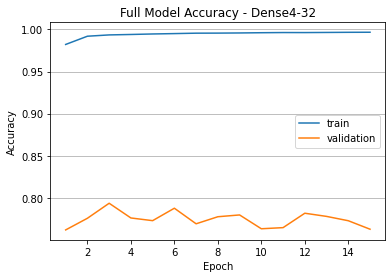

 ------------------------------------------------------------- 


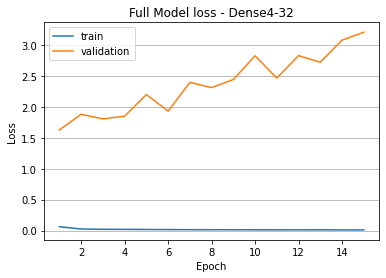

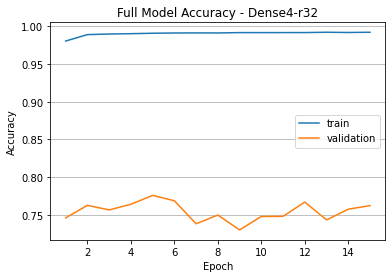

 ------------------------------------------------------------- 


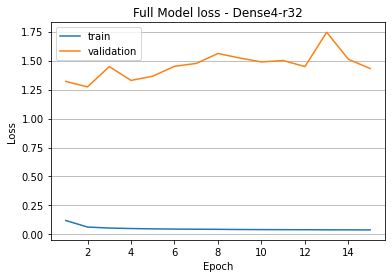

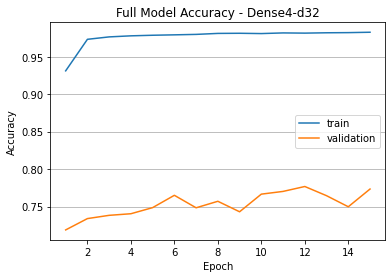

 ------------------------------------------------------------- 


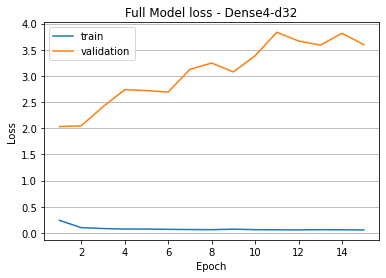

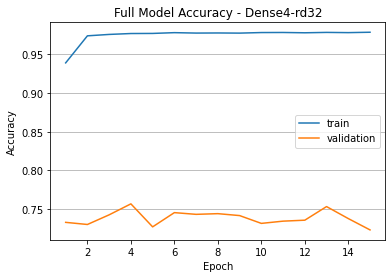

 ------------------------------------------------------------- 


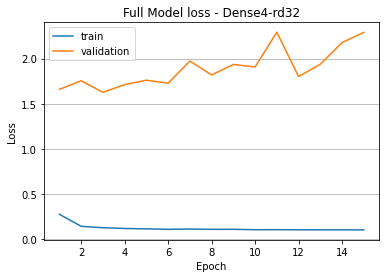

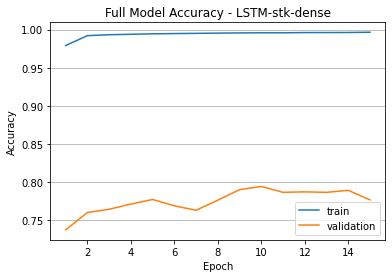

 ------------------------------------------------------------- 


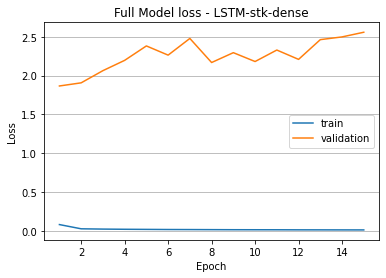

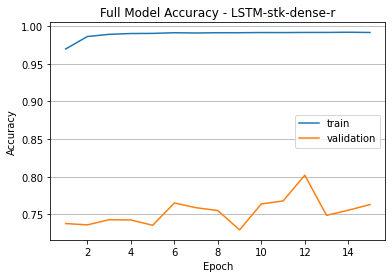

 ------------------------------------------------------------- 


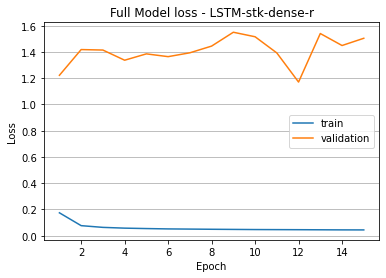

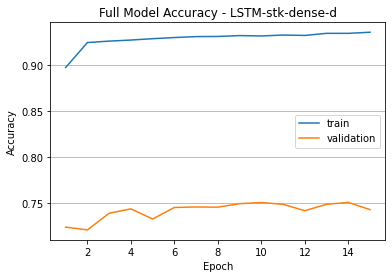

 ------------------------------------------------------------- 


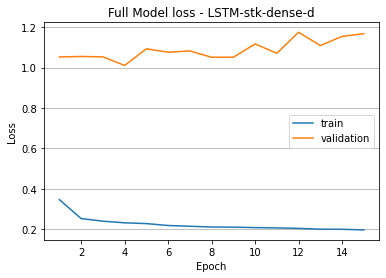

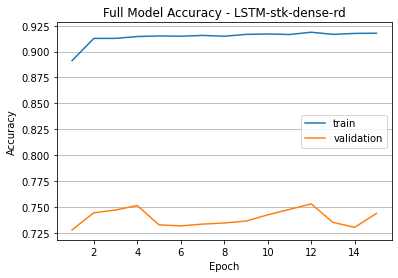

 ------------------------------------------------------------- 


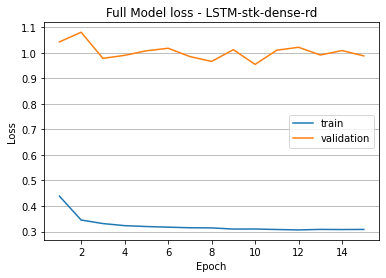







Comparing the models directly: 



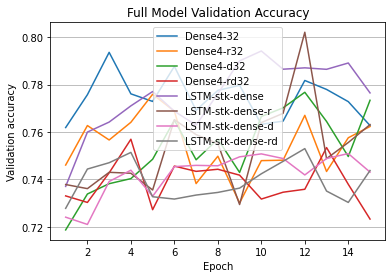

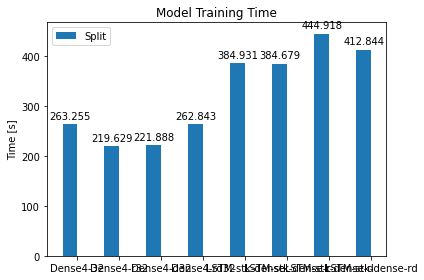

In [ ]:
# Generate plots:


def plot_histories(lst_models, lst_histories, sessionname=""):
  """ 
  Create nice charts.
  lst_models: list with model objects
  lst_historie: list with histories
  lst_trn_times: list with raining times [s]
  """
#  "Accuracy"
  for i in range(len(lst_models)):
    history = lst_histories[i]
    modelname = lst_models[i].name
    epoch_lbl = np.arange(len(history.history['accuracy'])) + 1
    plt.plot(epoch_lbl, history.history['accuracy'])
    plt.plot(epoch_lbl, history.history['val_accuracy'])
    plt.title('{} Model Accuracy - {}'.format(sessionname, modelname))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.grid(axis = 'y')
    # plt.legend(['train', 'validation'], loc='lower right')
    plt.legend(['train', 'validation'], loc='best')
    plt.savefig('myimage{}.png'.format(modelname), format='png', dpi=1200)
    plt.show()
    print(" ------------------------------------------------------------- ")

# "Loss"
    epoch_lbl = np.arange(len(history.history['loss'])) + 1
    plt.plot(epoch_lbl, history.history['loss'])
    plt.plot(epoch_lbl, history.history['val_loss'])
    plt.title('{} Model loss - {}'.format(sessionname, modelname))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    # plt.legend(['train', 'validation'], loc='upper right')
    plt.legend(['train', 'validation'], loc='best')
    plt.grid(axis = 'y')
    plt.savefig('myimage {}.png'.format(modelname), format='png', dpi=1200)
    plt.show()
    print("\n\n==============================================================\n")


# Accuracy across models:
  print("\n\n==============================================================\n")

  print("Comparing the models directly: \n")
  epoch_lbl = np.arange(len(lst_histories[0].history['val_accuracy'])) + 1
  for i in range(len(lst_models)):
    model = lst_models[i]
    hist = lst_histories[i]
    plt.plot(epoch_lbl, hist.history['val_accuracy'], label=model.name)

  plt.title('{} Model Validation Accuracy'.format(sessionname))
  plt.ylabel('Validation accuracy')
  plt.xlabel('Epoch')
  plt.grid(axis = 'y')
  # plt.legend(loc='lower right')
  plt.legend(loc='best')
  plt.savefig('compare.png' , format='png', dpi=1200)
  plt.show()
  print("\n\n")

# -----------------------------------  

def plot_training_times(lst_sessions, lst_models, lst_trntimes):
  """
  Plots the training times.
  Expects lst_sessions with two strings , e.g. "split" and "full"
  Expects lst_trntmes with two lists of times , for "split" and "full"
  """
  labels = [model.name for model in lst_models]
  x = np.arange(len(labels))
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  rectangles = list()
  rectangles.append(ax.bar(x - width/2, lst_trntimes[0], width, label=lst_sessions[0]))
  #rectangles.append(ax.bar(x + width/2, lst_trntimes[1], width, label=lst_sessions[1]))

  ax.set_ylabel('Time [s]')
  ax.set_title('Model Training Time')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

  for rc in rectangles:
    autolabel(rc)

  fig.tight_layout()
  plt.savefig('time.png', format='png', dpi=1200)
  plt.show()  


# ==========================================================================  

# order is important for the following:
# "Split" means we use original training dataset split in training+validation
# "Full" means we use the full original training dataset for training and the
# entire "Test" dataset for validation:
lst_sessions = ["Split", "Full"]
lst_trtimes = [ lst_trn_times_full]

# Generate plots for the train-validation split:
#plot_histories(lst_models_split, lst_hists_split, sessionname=lst_sessions[0])


# Generate plots for the FULL training and FULL testing datasets:
plot_histories(lst_models_full, lst_hists_full, sessionname=lst_sessions[1])

plot_training_times(lst_sessions, lst_models_full, lst_trtimes)
